# Study of LIDAR data processing

In [8]:
%pylab inline
import pandas as pd
import numpy

Populating the interactive namespace from numpy and matplotlib


In [9]:
import os
os.getcwd()

'C:\\Users\\rd73\\Documents\\Work\\SWEPT2\\git\\Python'

In [10]:
input_sample_fname = "../../samples/LIDAR/Data pack 25/00/2138233_23081400_25.scn"

In [11]:
campaign_code = ""
campaign_number = ""
rays_in_scan = 0
start_time = None
with open( input_sample_fname ) as fh:
    header_lines = []
    for i in range(10):
        header_lines.append( fh.readline().strip() )
        print i,"\t",header_lines[-1]
        
    campaign_code = header_lines[1].split(":\t")[1]
    campaign_number = header_lines[2].split(":\t")[1]
    rays_in_scan = int( header_lines[3].split(":\t")[1])
    start_time = header_lines[4][13:]
    #start_time = "".join(start_time)

0 	Filename:	C:\Lidar\Data\2014\201408\20140823\00\2138233_23081400_25.scn
1 	Campaign code:	altenbruch2 nacelle t1 a2 dg 0406 1357
2 	Campaign number:	304
3 	Rays in scan:	21
4 	Start time: 	00:01:03
5 	Range gate	Doppler	Intensity	Ray time	Az	El	Pitch	Roll
6 	0	38.618607	0.919469	00:01:03	150	0	1.538	-0.525
7 	1	-39.102631	0.967835	00:01:03	150	0	1.538	-0.525
8 	2	3.780688	1.016727	00:01:03	150	0	1.538	-0.525
9 	3	2.595855	1.020028	00:01:03	150	0	1.538	-0.525


In [12]:
print campaign_code
print campaign_number
print rays_in_scan
print start_time

altenbruch2 nacelle t1 a2 dg 0406 1357
304
21
00:01:03


In [13]:
lidar_df = pd.read_csv( input_sample_fname, header=5,sep="\t")

In [14]:
len(lidar_df)

336

In [15]:
lidar_df.head()

,Range gate,Doppler,Intensity,Ray time,Az,El,Pitch,Roll
0,0,38.618607,0.919469,00:01:03,150,0,1.538,-0.525
1,1,-39.102631,0.967835,00:01:03,150,0,1.538,-0.525
2,2,3.780688,1.016727,00:01:03,150,0,1.538,-0.525
3,3,2.595855,1.020028,00:01:03,150,0,1.538,-0.525
4,4,5.385946,1.032966,00:01:03,150,0,1.538,-0.525


Given that there are 21 rays in the scan, there must be 336 / 21 = 16 range gates in each one

In [16]:
lidar_df.describe()

,Range gate,Doppler,Intensity,Az,El,Pitch,Roll
count,336.000000,336.000000,336.000000,336.000000,336.0,336.000000,336.000000
mean,7.500000,6.885188,1.054403,180.000000,0.0,0.508286,-0.432667
std,4.616647,9.015529,0.040949,14.132845,0.0,0.699897,1.821982
min,0.000000,-39.599499,0.887557,150.000000,0.0,-0.706000,-3.993000
25%,3.750000,3.685137,1.035864,174.000000,0.0,0.008000,-1.035000
50%,7.500000,4.908191,1.060562,180.000000,0.0,0.416000,-0.321000
75%,11.250000,6.766659,1.084435,186.000000,0.0,1.232000,0.699000
max,15.000000,38.618607,1.120916,210.000000,0.0,1.640000,3.454000


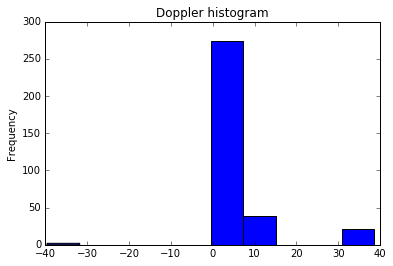

In [17]:
_ = lidar_df['Doppler'].plot(kind="hist",title="Doppler histogram")

The distribution of Doppler values shows some large positive and negative outliers

In [18]:
lidar_df['Doppler'].describe()

count    336.000000
mean       6.885188
std        9.015529
min      -39.599499
25%        3.685137
50%        4.908191
75%        6.766659
max       38.618607
Name: Doppler, dtype: float64

Given that the 25% to 75% percentile range is 3.7 to 6.8 perhaps we can ignore the outliers?

In [19]:
lidar_df[ lidar_df['Doppler'] > 20]['Range gate'].describe()

count    21.000000
mean      0.047619
std       0.218218
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: Range gate, dtype: float64

In [20]:
lidar_df[ lidar_df['Doppler'] < 0]['Range gate'].describe()

count    2.000000
mean     0.500000
std      0.707107
min      0.000000
25%      0.250000
50%      0.500000
75%      0.750000
max      1.000000
Name: Range gate, dtype: float64

In [21]:
lidar_df[ lidar_df['Doppler'] < 0]

,Range gate,Doppler,Intensity,Ray time,Az,El,Pitch,Roll
1,1,-39.102631,0.967835,00:01:03,150,0,1.538,-0.525
64,0,-39.599499,0.967314,00:01:09,171,0,1.640,1.821


Negative outlier values are only seen twice in the dataset, and only when scanning with very low range gate i.e. near to the LIDAR and in this case near to the turbine.

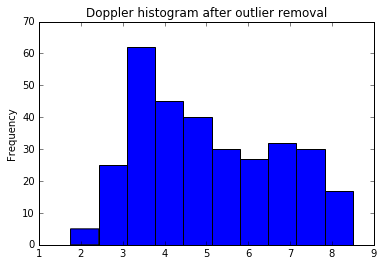

In [22]:
max_doppler = lidar_df['Doppler'].max()
lidar_df = lidar_df[ lidar_df['Doppler'] > 0 ]
lidar_df = lidar_df[ lidar_df['Doppler'] < max_doppler * 0.75 ]
_ = lidar_df['Doppler'].plot(kind="hist",title="Doppler histogram after outlier removal")

Now apply range gate transformation based on web search for Galion 4000 LIDAR systems. The range gates are 30 metres in length and the data is aggregated over that length. Use the centre of each range gate as a point location:

In [23]:
lidar_df['Range'] = lidar_df['Range gate'] * 30 + 15

Convert azimuth into radians for use with trig functions:

In [24]:
lidar_df['Az_radians'] = lidar_df['Az'] * pi / 180

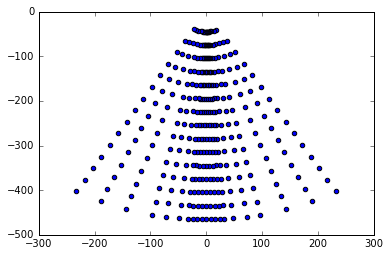

In [25]:
lidar_df['x'] = sin(lidar_df['Az_radians']) * lidar_df['Range']
lidar_df['y'] = cos(lidar_df['Az_radians']) * lidar_df['Range']
_ = plt.scatter(lidar_df['x'],lidar_df['y'])

Plot the data points onto a grid and do bilinear interpolation to create an image.

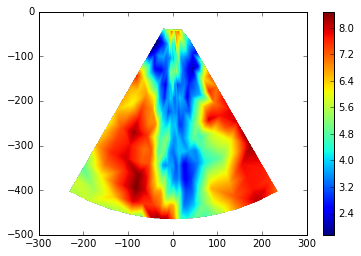

In [36]:
from scipy.interpolate import griddata
points = lidar_df.as_matrix(columns=['y','x'])
values = lidar_df['Doppler']

grid_x,grid_y = np.mgrid[300:-300:-600j,0:-500:-500j]

gridded = griddata( points,values,(grid_y,grid_x),method='linear')
gridded_rot = numpy.rot90( gridded, k=3 )

_ = plt.imshow(gridded_rot,extent=(-300,300,-500,0))
_ = plt.colorbar()

## Extracting the wake
We would like to pull out just the data points which are within the wake and exclude any that are in the free stream. A common way to do this is to collect all points that are half the maximum value.

In [60]:
max_in_grid = gridded_rot[ ~numpy.isnan( gridded_rot ) ].max()
fwhm = max_in_grid / 2.0

In [61]:
filtered_grid = numpy.minimum( gridded_rot, fwhm )
filtered_grid[ filtered_grid == fwhm ] = numpy.nan

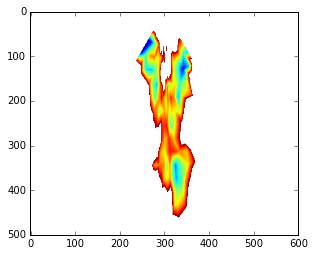

In [62]:
_ = plt.imshow( filtered_grid )

Now for each row of data, work out the mean value of wind speed. This can then be plotted as a percentage drop against maximum wind speed in the data (assumed to be free stream):

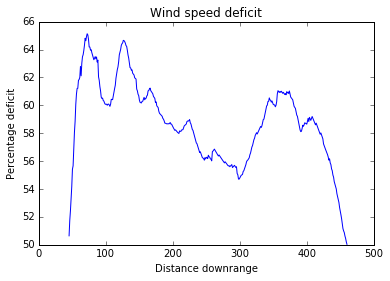

In [63]:
row_means = numpy.nanmean( filtered_grid ,1)
plt.plot(100 * (1 - row_means / max_in_grid ))
plt.title('Wind speed deficit')
plt.ylabel('Percentage deficit')
_ = plt.xlabel('Distance downrange')

# Manipulating VTK files with Paraview
Now investigate the loading and manipulating of VTK files through use of the Paraview Python libraries.

## Loading Paraview libraries
Paraview provides a Python shell **pvpython** which is setup with the necessary include paths to enable the use of the libraries. Through investigation of load orders and module load paths, the below was determined as the required approach to utilise the Paraview libraries in IPython.

In [1]:
import sys
#paraview_path = 'c:/program files (x86)/Paraview 4.3.1'
paraview_path = 'c:/program files/Paraview 5.1.0'
#paraview_version = 'paraview-4.3'
paraview_version = 'paraview-5.1'
#paraview_path = 'c:/program files/Paraview 4.4.0'
sys.path = ["%s/lib/%s/site-packages/"%(paraview_path,paraview_version),
            "%s/lib/%s/site-packages/vtk"%(paraview_path,paraview_version)
           ] + sys.path
import os
os.environ['PATH'] = "%s/bin;"%paraview_path + os.environ['PATH']
import paraview.simple

paraview version 5.1.0


## Loading VTK files
The provided VTK files were presented as a set of partial meshes, the filenames were not intuitively related to their contents. Paraview GUI was used to interactively examine the files to find some suitable for beginning basic visualisation and manipulation investigations. By aggregating all files with name matching 'large_turbine_solar_refined\_0\_\*' a complete data set was discovered. Attempting to load these files as a group in Paraview GUI caused Paraview to assume that they were timesteps and treated them as such. Individual loading of the files side-stepped this issue.

Open up all the discovered data files into an array of VTK data objects

In [2]:
import glob
dataFiles = glob.glob( 
    'C:/Users/rd73/Documents/Work/SWEPT2/samples/CFD/large_turbine_solar_refined_P6_OUTPUT/large_turbine_solar_refined_0_*')

vtkData = []
for d in dataFiles:
    vtkData.append( paraview.simple.OpenDataFile( d ))

Join the datasets together so as to merge them into one.

In [3]:
vtkData = paraview.simple.AppendDatasets( *vtkData )

## Slicing the object
In order to compare planar LIDAR data with 3-d CFD output, a slice plane is required to extract the same data. In our LIDAR data the scanning plane is horizontal. Extract a horizontal slice by setting the normal vector of the plane to the Y-axis, including cell coordinates in the output for use in further processing.

In [4]:
slicer = paraview.simple.Slice()
slicer.Input = vtkData
slicer.Crinkleslice = True
slicer.SliceType.Origin = [0,0.5,0]
slicer.SliceType.Normal = [0,1,0]
slicer.UpdatePipeline()

cd = paraview.simple.CellDatatoPointData( slicer, PassCellData=1)

## Export of data from the slice
Data from the slice needs to be exported into a format usable in other tools. CSV is a reasonable choice:

In [6]:
#paraview.simple.Show(vtkData)
writer = paraview.simple.CreateWriter('turbine-out.csv',cd)
writer.FieldAssociation = "Points"
writer.UpdatePipeline()
with open('turbine-out.csv','r') as fh:
    for l in range(10):
        print fh.readline(),

"T","V:0","V:1","V:2","p","rho","Points:0","Points:1","Points:2"
288.15,1.4241,0,0,1.0133e+005,1.2252,0,0.44619,1.5
288.15,1.4241,0,0,1.0133e+005,1.2252,0,0.44619,1.75
288.15,1.4241,0,0,1.0133e+005,1.2252,0,0.58405,1.75
288.15,1.4241,0,0,1.0133e+005,1.2252,0,0.58405,1.6406
288.15,1.4241,0,0,1.0133e+005,1.2252,0,0.58405,1.5313
288.15,1.4241,0,0,1.0133e+005,1.2252,0,0.58405,1.5
288.15,1.4241,0,0,1.0133e+005,1.2252,0,0.44619,-1.75
288.15,1.4241,0,0,1.0133e+005,1.2252,0,0.44619,-1.5
288.15,1.4241,0,0,1.0133e+005,1.2252,0,0.58405,-1.5


In [33]:
paraview.simple.Disconnect()

## Replicating the wake diagram produced from LIDAR data
Now to try to perform similar analysis on the data as was done with the LIDAR data. This will follow a number of steps:
  1. Cut the data down to a box similar to the LIDAR data extent.
  1. Sample points in the same pattern as done with the LIDAR scan i.e. matching range gates and azimuths.
  1. Perform bilinear interpolation to fill the grid.
  1. Extract wake properties such as wind speed deficit.

In [34]:
import pandas
import numpy

cfd_df = pandas.read_csv('turbine-out.csv')
cfd_df.rename( columns = { 'Points:0':'X','Points:1':'Y','Points:2':'Z'},inplace=True)
cfd_df.describe()

,T,V:0,V:1,V:2,p,rho,X,Y,Z
count,1.087990e+05,108799.000000,108799.000000,108799.000000,108799.00000,1.087990e+05,1.087990e+05,108799.000000,108799.000000
mean,2.881500e+02,1.321133,0.001285,0.014234,101329.86305,1.225200e+00,1.478085e+01,0.504857,0.000557
std,5.519521e-10,0.126103,0.020015,0.022809,1.16222,4.718470e-13,3.784304e+00,0.023588,0.443509
min,2.881500e+02,0.890300,-0.030625,-0.083937,101320.00000,1.225200e+00,-1.110200e-16,0.424040,-1.750000
25%,2.881500e+02,1.245700,-0.007628,0.000003,101330.00000,1.225200e+00,1.279300e+01,0.492190,-0.218750
50%,2.881500e+02,1.379200,-0.000420,0.008012,101330.00000,1.225200e+00,1.521500e+01,0.503910,0.000000
75%,2.881500e+02,1.424450,0.006055,0.022292,101330.00000,1.225200e+00,1.761700e+01,0.503910,0.218750
max,2.881500e+02,1.461300,0.171970,0.115090,101330.00000,1.225200e+00,2.000000e+01,0.584050,1.750000


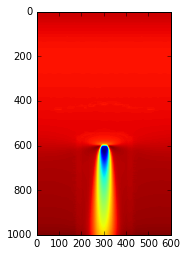

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

cfd_df['Vmag'] = numpy.sqrt( numpy.square( cfd_df['V:0']) + numpy.square( cfd_df['V:1']) + numpy.square( cfd_df['V:2']))
points = cfd_df.as_matrix(columns=['Z','X'])
#values = df['V:0']
values = cfd_df['Vmag']

grid_x,grid_z = numpy.mgrid[0:20:1000j,-1.75:1.75:600j]

gridded = griddata( points,values,(grid_z,grid_x),method='linear')

_ = plt.imshow(gridded)

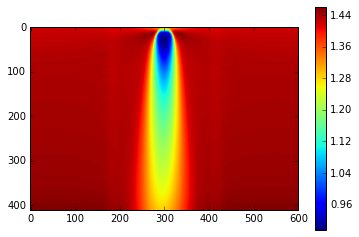

In [36]:
sub_im = gridded[ 590:1000,0:600]
plt.imshow(sub_im)
_ = plt.colorbar()

## Sampling points from the slice of VTK data
Now that we have an image of a similar area to that obtained from the LIDAR data, try to prepare a similar set of data. Set up an array of sample points that approximate the positions of data points returned by the LIDAR system.

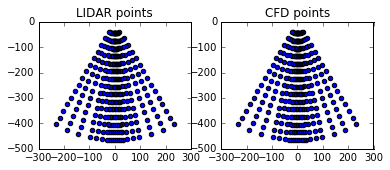

In [123]:
ranges = [ (x+1)*30+15 for x in range(15)]

# Borrow the values from the LIDAR dataset for beam azimuth angle
rad_angles = [ x * numpy.pi / 180 for x in lidar_df['Az'].unique().tolist() ]
sample_points = []
for ang in rad_angles:
    for ra in ranges:
        sample_points.append( (ang, ra ))

sample_df = pandas.DataFrame( sample_points )
sample_df.columns = ['radians','ranges']
sample_df['x'] = sample_df['ranges'] * numpy.sin( sample_df['radians'])
sample_df['y'] = sample_df['ranges'] * numpy.cos( sample_df['radians'])

fig = plt.figure()
lidar_plt = fig.add_subplot(121,aspect='equal',title='LIDAR points')
cfd_plt = fig.add_subplot(122,aspect='equal',title='CFD points')
_ = lidar_plt.scatter(lidar_df['x'],lidar_df['y'])
_ = cfd_plt.scatter(sample_df['x'],sample_df['y'])

Scale and transpose the coordinates to put them within the range of the imagery we have.

In [124]:
sample_df['scaled_x'] = sample_df['x'] + 300
sample_df['scaled_y'] = abs(sample_df['y']) * 410/500.0

Now redo the interpolation but only onto the coordinates we have calculated. Use the nearest point to avoid changing data values further:

In [125]:
point_data = sub_im.flatten(order='C')

points_coords = []
for y in range(410):
    for x in range(600):
        points_coords.append((x,y))

interp_points = griddata( points_coords, point_data, ( sample_df['scaled_x'], sample_df['scaled_y']), method='nearest')

And then interpolate onto an image for display:

In [126]:
sample_df['interp_points'] = interp_points

grid_x,grid_y = numpy.mgrid[-300:300:600j,0:-500:-500j]
new_grid = griddata( sample_df[['x','y']],sample_df['interp_points'],(grid_x,grid_y),method='linear')

Image must be rotated clockwise 90 degrees to match with LIDAR.

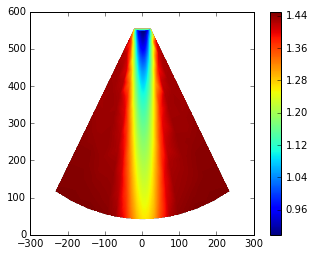

In [127]:
new_grid_rot = numpy.rot90(new_grid,k=3)
plt.imshow(new_grid_rot,extent=(-300,300,0,600))
_ = plt.colorbar()

There is not enough variation between minimum and maximum to perform an extraction of FWHM. Instead take all the points below the 50th percentile of the value distribution, and set all points at or above that value to NaN.

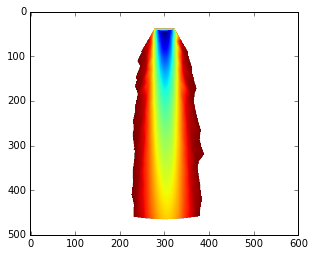

In [128]:
percentile_50 = numpy.percentile( new_grid_rot[ ~numpy.isnan( new_grid_rot) ], 50 )
filtered_img = numpy.minimum( new_grid_rot, percentile_50 )
filtered_img[ filtered_img == percentile_50 ] = numpy.nan
_ = plt.imshow( filtered_img )

Now we have an extraction of the wake itself, compare the velocity to that of the free stream to work out the wind speed deficit similar to how we have done for the LIDAR:

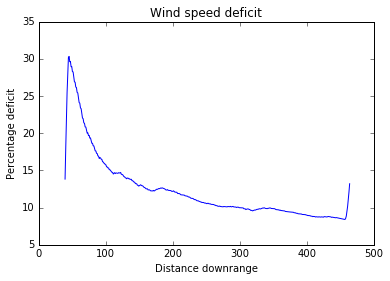

In [129]:
cfd_row_means = numpy.nanmean( filtered_img ,1)
max_in_cfd_grid = sub_im.max()
plt.plot(100 * (1 - cfd_row_means / max_in_cfd_grid ))
plt.title('Wind speed deficit')
plt.ylabel('Percentage deficit')
_ = plt.xlabel('Distance downrange')

## Notes
This analysis differs from the LIDAR analysis in several ways:
  1. Data value range does not allow for extraction of wake via filtering on full-width half maximum (FWHM)
  1. The sampling points all come from a single instance in time
  1. There is no information about the location of the 'turbine'
  1. The simulation uses an actuator disk as an approximation of a turbine
  1. Maximum velocity of 1.46 is much lower than maximum velocity seen in the LIDAR data which is 6.77 at the 75th percentile
  

# Comparing the two datasets
Now that we have homed in on a similar metric to extract from each dataset, we can compare them:

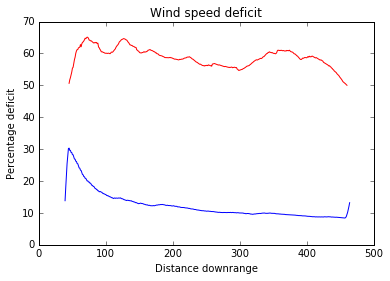

In [130]:
plt.plot(100 * (1 - cfd_row_means / max_in_cfd_grid ))
plt.plot(100 * (1 - row_means / max_in_grid ), 'r-')
plt.title('Wind speed deficit')
plt.ylabel('Percentage deficit')
_ = plt.xlabel('Distance downrange')

We are comparing two very different scenarios here, but an observation one could make might be that the deficit is __much__ greater for a real wind turbine than it is for a simulated actuator disk.